# IPP Transcriptomics analysis

#### Load Libraries

In [1]:
library(DESeq2)
library(reshape2)
library(pheatmap)
library(RColorBrewer)
library(ggplot2)
library(VennDiagram)
library(gridExtra)
library(GenomicFeatures)
library(org.EcK12.eg.db)
library(clusterProfiler)
library(RCy3)
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

NULL

#### Read genome information and annotation

In [2]:
fai <- Rsamtools::scanFaIndex("./data/NC_017638_pBbA5c_pTrc99A.fasta")
chrominfo <- data.frame(chrom=as.character(seqnames(fai)),
                        length=end(fai),
                        is_circular=rep(FALSE, length(fai)))
txdb <- makeTxDbFromGFF("./data/NC_017638_pBbA5c_pTrc99A.gtf",
                        chrominfo=chrominfo,
                        dbxrefTag="gene_id")

Found more than one class "connection" in cache; using the first, from namespace 'BiocGenerics'
Also defined by ‘RJSONIO’
Import genomic features from the file as a GRanges object ... Found more than one class "file" in cache; using the first, from namespace 'BiocGenerics'
Also defined by ‘RJSONIO’
Found more than one class "file" in cache; using the first, from namespace 'BiocGenerics'
Also defined by ‘RJSONIO’
Found more than one class "file" in cache; using the first, from namespace 'BiocGenerics'
Also defined by ‘RJSONIO’
Found more than one class "file" in cache; using the first, from namespace 'BiocGenerics'
Also defined by ‘RJSONIO’
Found more than one class "file" in cache; using the first, from namespace 'BiocGenerics'
Also defined by ‘RJSONIO’
Found more than one class "file" in cache; using the first, from namespace 'BiocGenerics'
Also defined by ‘RJSONIO’
Found more than one class "connection" in cache; using the first, from namespace 'BiocGenerics'
Also defined by ‘RJSONIO

#### Read raw counts and library information

In [3]:
countData <- read.table("./data/RNA_Seq_counts_s1.txt",sep="\t",header=TRUE,row.name=1)
colData <- read.table("./data/RNA_Seq_library.txt",sep="\t",header=TRUE,row.name=1)
rowData <- countData[,1:5]

colnames(countData)[6:23] <- sapply(lapply(strsplit(colnames(countData)[6:23],"[.]"),"[",c(3:5)), paste, collapse="-")
countData <- countData[,c(18:20,23,21:22,6:8,11,9:10,12:13,16:17,14:15)]

colData <- as.data.frame(sapply(colData[, 2:4], factor))
rownames(colData) <- colnames(countData)
colData$strain <- relevel(colData$strain, "WT")

head(countData)
colData
head(rowData)

,WT-0-1,WT-0-2,WT-1-1,WT-1-2,WT-12-1,WT-12-3,3A-0-1,3A-0-2,3A-1-1,3A-1-2,3A-12-1,3A-12-2,3Amk-0-1,3Amk-0-2,3Amk-1-2,3Amk-1-3,3Amk-12-1,3Amk-12-2
thrL,29,16,26,17,10,6,38,43,6,39,182,190,14,62,0,4,95,93
thrA,749,816,1453,836,184,304,5215,3225,722,949,27007,21356,4198,5059,854,261,4031,2094
thrB,424,642,1340,668,40,120,3214,2808,427,860,5091,4297,3525,3827,726,316,665,437
thrC,327,294,294,190,3,28,1311,1133,119,221,1749,1782,1063,941,150,28,313,129
yaaX,13,16,33,6,0,0,75,30,25,13,58,40,60,76,33,0,3,5
yaaA,479,640,282,93,4,5,610,434,69,139,22,6,352,288,223,43,4,14


,strain,time,replicate
WT-0-1,WT,0,1
WT-0-2,WT,0,2
WT-1-1,WT,1,1
WT-1-2,WT,1,2
WT-12-1,WT,12,1
WT-12-3,WT,12,3
3A-0-1,3A,0,1
3A-0-2,3A,0,2
3A-1-1,3A,1,1
3A-1-2,3A,1,2


,Chr,Start,End,Strand,Length
thrL,NC_017638.1,190,255,+,66
thrA,NC_017638.1,338,2800,+,2463
thrB,NC_017638.1,2802,3734,+,933
thrC,NC_017638.1,3735,5021,+,1287
yaaX,NC_017638.1,5235,5531,+,297
yaaA,NC_017638.1,5684,6460,-,777


#### Combine counts for genes on both chromosome and plasmid

In [4]:
countData[c("AtoB","atoB","NudB","nudB"),]
countData[c('atoB'),] <- countData[c('AtoB'),] + countData[c('atoB'),]
countData[c('nudB'),] <- countData[c('NudB'),] + countData[c('nudB'),]
countData <- countData[!rownames(countData) %in% c("AtoB","NudB"),]
countData[c("atoB","nudB"),]

,WT-0-1,WT-0-2,WT-1-1,WT-1-2,WT-12-1,WT-12-3,3A-0-1,3A-0-2,3A-1-1,3A-1-2,3A-12-1,3A-12-2,3Amk-0-1,3Amk-0-2,3Amk-1-2,3Amk-1-3,3Amk-12-1,3Amk-12-2
AtoB,112,98,104,93,61,106,1018,847,51225,99833,28011,25947,648,571,109268,42560,11039,9800
atoB,35,36,71,38,24,45,427,405,14957,35892,15382,13213,326,268,43383,16157,5015,3718
NudB,1008,1057,1184,915,463,589,14769,13108,255654,501148,591954,468219,7161,5796,257767,134570,217071,131511
nudB,921,1068,1243,938,458,584,14796,12735,249869,492340,577785,454823,6977,5932,254037,131512,205823,114449


,WT-0-1,WT-0-2,WT-1-1,WT-1-2,WT-12-1,WT-12-3,3A-0-1,3A-0-2,3A-1-1,3A-1-2,3A-12-1,3A-12-2,3Amk-0-1,3Amk-0-2,3Amk-1-2,3Amk-1-3,3Amk-12-1,3Amk-12-2
atoB,147,134,175,131,85,151,1445,1252,66182,135725,43393,39160,974,839,152651,58717,16054,13518
nudB,1929,2125,2427,1853,921,1173,29565,25843,505523,993488,1169739,923042,14138,11728,511804,266082,422894,245960


#### Calculate the percentage of pathway genes in total transcript counts

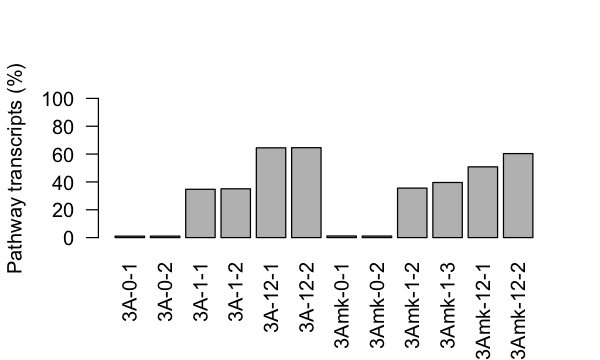

In [5]:
options(repr.plot.width=5, repr.plot.height=3)
Pathway_genes <- c("atoB","mvaS","mvaA","MK","PMK-fixed","nudB","PMD")
barplot(colSums(countData[Pathway_genes,colData$strain!="WT"])/colSums(countData[,colData$strain!="WT"])*100, las=2,
        ylab = "Pathway transcripts (%)", ylim=c(0,100))
options(repr.plot.width=7, repr.plot.height=7)

#### Creat a DESeq object

In [6]:
dds <- DESeqDataSetFromMatrix(countData = countData, colData = colData, design = ~ strain + time + strain:time)
rowRanges(dds) <- transcriptsBy(txdb,by = 'gene')[rownames(dds)]
nrow(dds)
head(dds)

[1] 4187

class: DESeqDataSet 
dim: 6 18 
metadata(1): version
assays(1): counts
rownames(6): thrL thrA ... yaaX yaaA
rowData names(0):
colnames(18): WT-0-1 WT-0-2 ... 3Amk-12-1 3Amk-12-2
colData names(3): strain time replicate

#### Calculate FPKM values and compare to protein levels

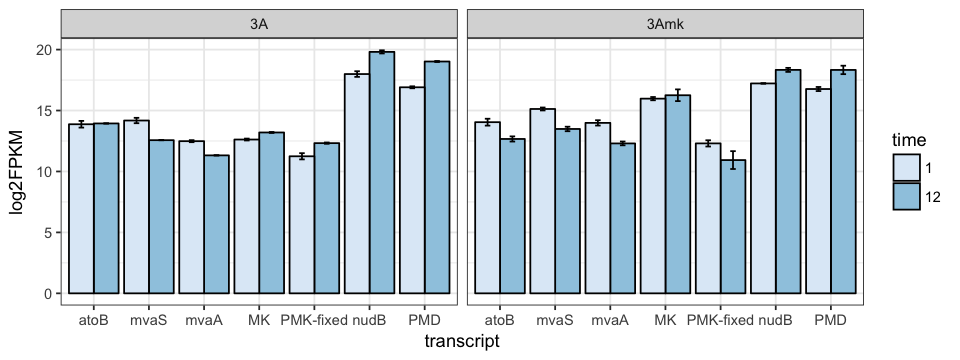

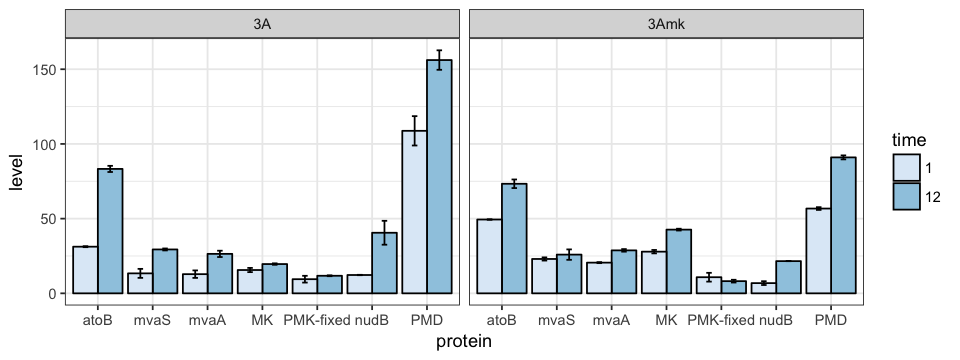

In [7]:
options(repr.plot.width=8, repr.plot.height=3)
ipp_fpkm <- log2(fpkm(dds)+1)

write.table(ipp_fpkm, file="./results/IPP_Transcriptomics_FPKM.txt", sep="\t", col.names = NA, quote = FALSE)

colData_sub <- subset(colData, strain!="WT" & time!=0)
FPKM_pathway <- melt(aggregate(t(ipp_fpkm[Pathway_genes,rownames(colData_sub)]), colData_sub[,1:2], mean, na.rm=T),
                              id.vars=c("strain","time"), variable.name="transcript", value.name="log2FPKM")
FPKM_pathway$sd <- melt(aggregate(t(ipp_fpkm[Pathway_genes,rownames(colData_sub)]), colData_sub[,1:2], sd, na.rm=T),
                                 id.vars=c("strain","time"), variable.name="transcript", value.name="sd")$sd

ggplot(FPKM_pathway, aes(x=transcript, y=log2FPKM, fill=time)) + ggplot2::facet_grid(~strain) + theme_bw() +
    geom_bar(stat="identity", color="black", position=position_dodge()) + scale_fill_brewer() +
    geom_errorbar(aes(ymin=log2FPKM-sd, ymax=log2FPKM+sd), width=.2, position=position_dodge(.9))

Pro <- read.table("./data/IPP_Proteomics.txt",sep="\t", header=TRUE, row.name=1, check.names = FALSE)
Pro_pathway <- melt(aggregate(t(Pro[Pathway_genes,rownames(colData_sub)]), colData_sub[,1:2], mean, na.rm=T),
                              id.vars=c("strain","time"), variable.name="protein", value.name="level")
Pro_pathway$sd <- melt(aggregate(t(Pro[Pathway_genes,rownames(colData_sub)]), colData_sub[,1:2], sd, na.rm=T),
                                 id.vars=c("strain","time"), variable.name="protein", value.name="sd")$sd

ggplot(Pro_pathway, aes(x=protein, y=level, fill=time)) + ggplot2::facet_grid(~strain) + theme_bw()  +
    geom_bar(stat="identity", color="black", position=position_dodge()) + scale_fill_brewer() +
    geom_errorbar(aes(ymin=level-sd, ymax=level+sd), width=.2, position=position_dodge(.9))
options(repr.plot.width=7, repr.plot.height=7)

#### Plot sample to sample distances

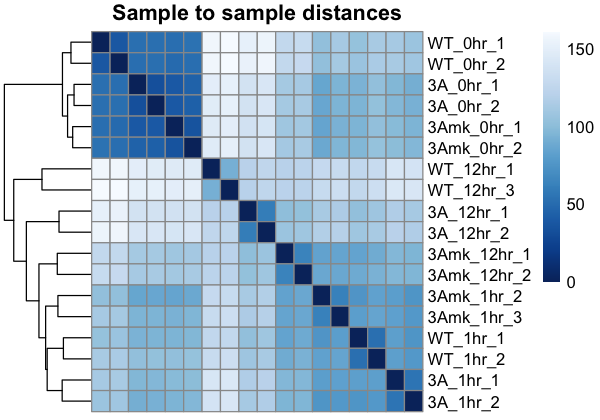

In [8]:
options(repr.plot.width=5, repr.plot.height=3.5)
rld <- rlog(dds, blind=FALSE)
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix(sampleDists)
colnames(sampleDistMatrix) <- NULL
rownames(sampleDistMatrix) <- paste0(rld$strain, "_", rld$time, "hr_", rld$replicate)
pheatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, col=colors,
         treeheight_col = 0, main="Sample to sample distances")
pheatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, col=colors,
         treeheight_col = 0, main="Sample to sample distances", filename="./results/RNA_Seq_Samples.pdf")
options(repr.plot.width=7, repr.plot.height=7)

#### Map gene name to ECK number (mapping from EcoCyc DH1)

In [9]:
gene2ECKnum <- read.table("./data/gene_ECKnum.txt",sep="\t",header=T,row.name=1,stringsAsFactors=F)
ECKnum2gene <- data.frame(gene = rownames(gene2ECKnum), row.names = gene2ECKnum$ECKnum, stringsAsFactors = F)
nrow(gene2ECKnum)
head(gene2ECKnum)

noECKnum <- rownames(dds)[which(!rownames(dds) %in% rownames(gene2ECKnum))]
length(noECKnum)
noECKnum

[1] 4137

,ECKnum
aaeA,ECK3230
aaeB,ECK3229
aaeR,ECK3232
aaeX,ECK3231
aas,ECK2832
aat,ECK0876


[1] 50

[1] "ECDH1ME8569_0029" "ECDH1ME8569_0032" "ECDH1ME8569_0303" "ykiB"            
 [5] "ECDH1ME8569_0485" "ybbV"             "ybfK"             "ECDH1ME8569_0691"
 [9] "ECDH1ME8569_0969" "ymfR"             "stfP"             "ECDH1ME8569_1165"
[13] "ECDH1ME8569_1226" "ymjB"             "ydaF"             "ECDH1ME8569_1311"
[17] "yneN"             "ynfP"             "ECDH1ME8569_1599" "ECDH1ME8569_1754"
[21] "ECDH1ME8569_1799" "ECDH1ME8569_1906" "ECDH1ME8569_1922" "yohH"            
[25] "yojO"             "yfdM"             "ECDH1ME8569_2338" "ECDH1ME8569_2430"
[29] "yqcG"             "ECDH1ME8569_2873" "ECDH1ME8569_2937" "tdcR"            
[33] "yrhD"             "ECDH1ME8569_3378" "ECDH1ME8569_3379" "ECDH1ME8569_3469"
[37] "yibV"             "ECDH1ME8569_3558" "ECDH1ME8569_3665" "ECDH1ME8569_3894"
[41] "ECDH1ME8569_3912" "ECDH1ME8569_3941" "yzfA"             "ECDH1ME8569_4200"
[45] "ECDH1ME8569_4247" "mvaS"             "mvaA"             "MK"              
[49] "PMK-fixed"        "PMD"

#### Map ECK number to org.EcK12.eg.db symbol

In [10]:
mapped <- mapIds(org.EcK12.eg.db, keys=rownames(ECKnum2gene), keytype="ALIAS", column="SYMBOL")
notmap <- ECKnum2gene[names(mapped[is.na(mapped)]),]
mapped <- mapped[!is.na(mapped)]
length(mapped)
head(mapped)
length(notmap)
notmap

'select()' returned 1:1 mapping between keys and columns


[1] 4093

ECK3230 ECK3229 ECK3232 ECK3231 ECK2832 ECK0876 
 "aaeA"  "aaeB"  "aaeR"  "aaeX"   "aas"   "aat"

[1] 44

[1] "croE" "glvC" "hokC" "insO" "rhoL" "yabQ" "yaiF" "yaiU" "ybeM" "ybfH"
[11] "ybfQ" "ychS" "yddJ" "ydeU" "yedM" "yfcT" "yfjV" "ygaR" "ygaY" "ygeL"
[21] "ygeN" "ygeQ" "yghY" "ygiA" "yhiK" "yifN" "yjgW" "yjhW" "yjiQ" "yjiV"
[31] "ykgN" "yliL" "ymfH" "ymgG" "ymgH" "yoaI" "yoeE" "ypjC" "ypjM" "yqaC"
[41] "yqaD" "yqgD" "ysdC" "yzcX"

#### Map gene name to org.EcK12.eg.db symbol

In [11]:
gene2symbol <- data.frame(symbol = mapped, row.names = ECKnum2gene[names(mapped),1], stringsAsFactors = F)
nrow(gene2symbol)
head(gene2symbol)
symbol2gene <- data.frame(gene = rownames(gene2symbol), row.names = gene2symbol$symbol, stringsAsFactors = F)
nrow(symbol2gene)
head(symbol2gene)

[1] 4093

,symbol
aaeA,aaeA
aaeB,aaeB
aaeR,aaeR
aaeX,aaeX
aas,aas
aat,aat


[1] 4093

,gene
aaeA,aaeA
aaeB,aaeB
aaeR,aaeR
aaeX,aaeX
aas,aas
aat,aat


#### Check the expression of genes not mapped to org.EcK12.eg.db

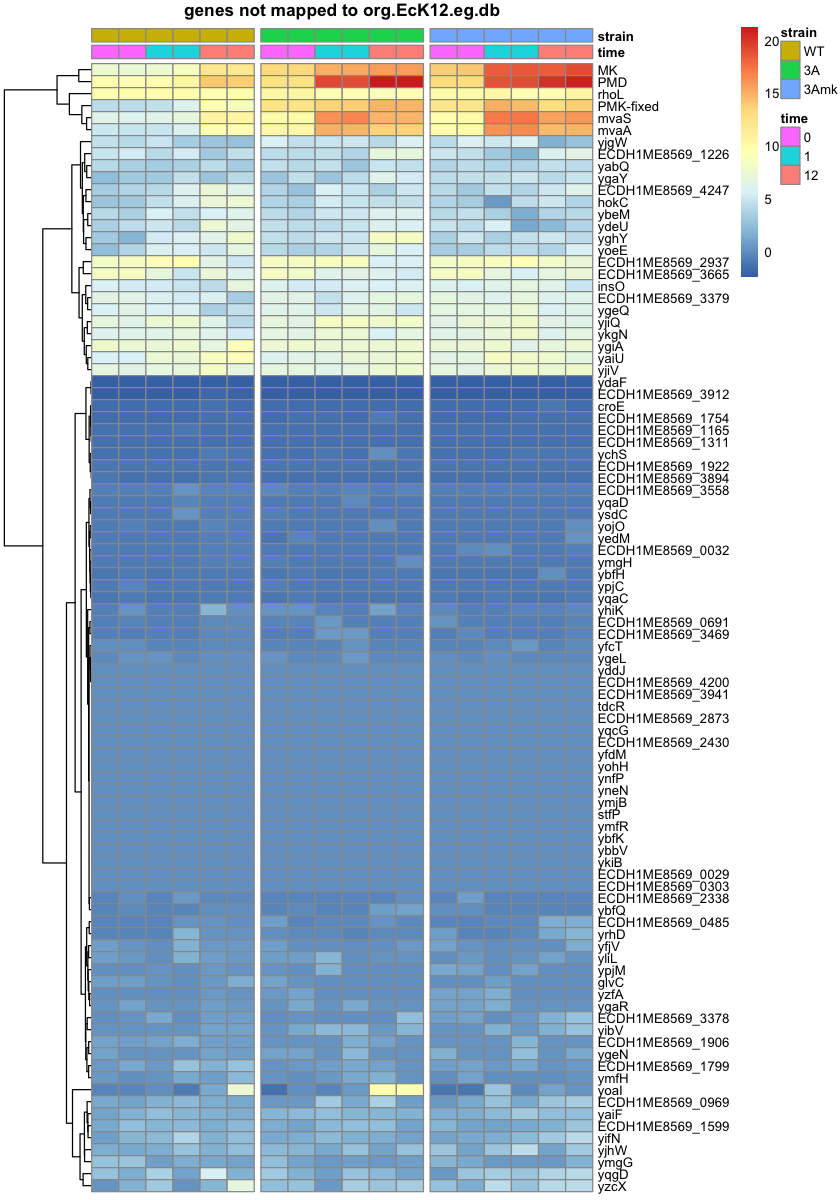

In [12]:
options(repr.plot.width=7, repr.plot.height=10)
df <- as.data.frame(colData(dds)[,c("time","strain")])
pheatmap(assay(rld)[c(noECKnum,notmap),], cluster_cols=FALSE, show_colnames=FALSE, annotation_col=df,
         gaps_col=c(6,12), main="genes not mapped to org.EcK12.eg.db", fontsize = 8)
options(repr.plot.width=7, repr.plot.height=7)

#### Plot the expression of genes with the highest variance

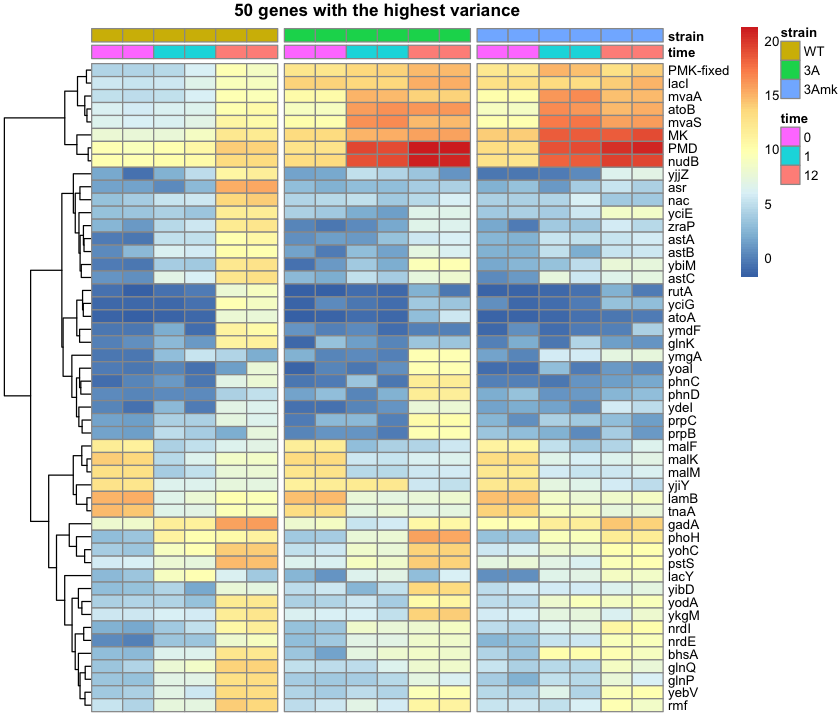

In [13]:
options(repr.plot.width=7, repr.plot.height=6)
select <- order(rowVars(assay(rld)),decreasing=TRUE)[1:50]
pheatmap(assay(rld)[select,], cluster_rows=TRUE, cluster_cols=FALSE, show_colnames=FALSE, annotation_col=df,
         gaps_col=c(6,12), main="50 genes with the highest variance", fontsize = 8)
options(repr.plot.width=7, repr.plot.height=7)

### Perform differential expression analysis

In [14]:
dds$group <- factor(paste0(dds$strain, dds$time))
design(dds) <- ~ group
dds <- DESeq(dds)
resultsNames(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Intercept"           "group_3A1_vs_3A0"    "group_3A12_vs_3A0"  
[4] "group_3Amk0_vs_3A0"  "group_3Amk1_vs_3A0"  "group_3Amk12_vs_3A0"
[7] "group_WT0_vs_3A0"    "group_WT1_vs_3A0"    "group_WT12_vs_3A0"

#### Testing with $\alpha$ < 0.1 and filtering with |log2(FoldChange)| > 1

In [15]:
alpha = 0.1
k = log2(2)

In [16]:
# Testing response of strain 3A at time 1
res3A_vs_WT_1 <- results(dds, alpha=alpha, contrast=c("group","3A1","WT1"))
summary(res3A_vs_WT_1)

res3A_vs_WT_1_up <- rownames(subset(res3A_vs_WT_1, padj < alpha & log2FoldChange > k))
res3A_vs_WT_1_down <- rownames(subset(res3A_vs_WT_1, padj < alpha & log2FoldChange < -k))

# Testing response of strain 3Amk at time 1
res3Amk_vs_WT_1 <- results(dds, alpha=alpha, contrast=c("group","3Amk1","WT1"))
summary(res3Amk_vs_WT_1)

res3Amk_vs_WT_1_up <- rownames(subset(res3Amk_vs_WT_1, padj < alpha & log2FoldChange > k))
res3Amk_vs_WT_1_down <- rownames(subset(res3Amk_vs_WT_1, padj < alpha & log2FoldChange < -k))

# Testing response of strain 3A at time 12
res3A_vs_WT_12 <- results(dds, alpha=alpha, contrast=c("group","3A12","WT12"))
summary(res3A_vs_WT_12)

res3A_vs_WT_12_up <- rownames(subset(res3A_vs_WT_12, padj < alpha & log2FoldChange > k))
res3A_vs_WT_12_down <- rownames(subset(res3A_vs_WT_12, padj < alpha & log2FoldChange < -k))

# Testing response of strain 3Amk at time 12
res3Amk_vs_WT_12 <- results(dds, alpha=alpha, contrast=c("group","3Amk12","WT12"))
summary(res3Amk_vs_WT_12)

res3Amk_vs_WT_12_up <- rownames(subset(res3Amk_vs_WT_12, padj < alpha & log2FoldChange > k))
res3Amk_vs_WT_12_down <- rownames(subset(res3Amk_vs_WT_12, padj < alpha & log2FoldChange < -k))


out of 4157 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 358, 8.6% 
LFC < 0 (down)   : 397, 9.6% 
outliers [1]     : 0, 0% 
low counts [2]   : 323, 7.8% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 4157 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 510, 12% 
LFC < 0 (down)   : 520, 13% 
outliers [1]     : 0, 0% 
low counts [2]   : 323, 7.8% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 4157 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 823, 20% 
LFC < 0 (down)   : 850, 20% 
outliers [1]     : 0, 0% 
low counts [2]   : 403, 9.7% 
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 4157 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 837, 20% 
LFC < 0 (down)   : 802, 

#### Plot venn diagrams of differentially expressed genes

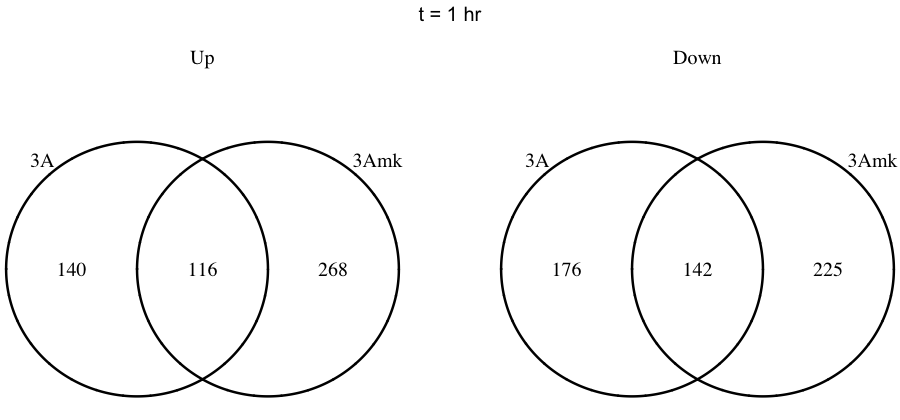

pdf 
  2

pdf 
  2

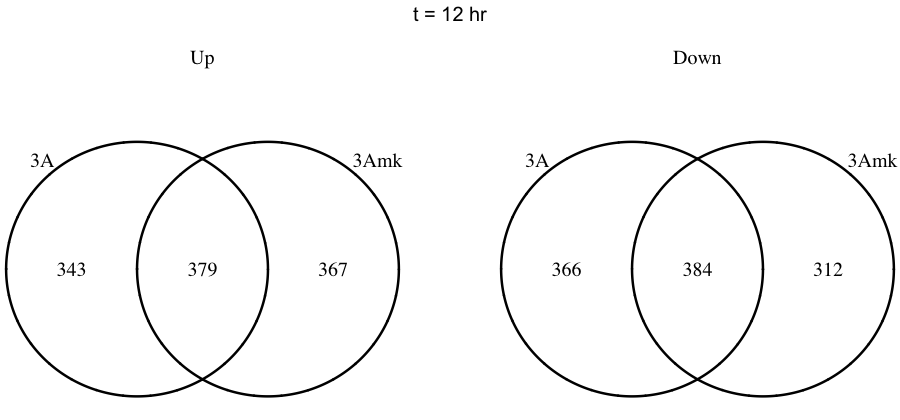

In [17]:
options(repr.plot.width=7.5, repr.plot.height=3.5)
pb <- rectGrob(gp=gpar(col='white'))
p1 <- venn.diagram(list("3A" = res3A_vs_WT_1_up, "3Amk" = res3Amk_vs_WT_1_up),NULL, 
                  scaled = F, cex = 1, cat.cex = 1, rotation.degree = 180, 
                  cat.pos = c(320,40), cat.just = list(c(0.5,0.5),c(0.2,0.5)), 
                  main = "Up")
p2 <- venn.diagram(list("3A" = res3A_vs_WT_1_down, "3Amk" = res3Amk_vs_WT_1_down),NULL,
                  scaled = F, rotation.degree = 180, cex = 1, cat.cex = 1,
                  cat.pos = c(320,40), cat.just = list(c(0.5,0.5),c(0.2,0.5)), 
                  main = "Down")
p3 <- venn.diagram(list("3A" = res3A_vs_WT_12_up, "3Amk" = res3Amk_vs_WT_12_up),NULL,
                  scaled = F, rotation.degree = 180, cex = 1, cat.cex = 1,
                  cat.pos = c(320,40), cat.just = list(c(0.5,0.5),c(0.2,0.5)), 
                  main = "Up")
p4 <- venn.diagram(list("3A" = res3A_vs_WT_12_down, "3Amk" = res3Amk_vs_WT_12_down),NULL,
                  scaled = F, rotation.degree = 0, cex = 1, cat.cex = 1,
                  cat.pos = c(320,40), cat.just = list(c(0.5,0.5),c(0.2,0.5)), 
                  main = "Down")
grid.arrange(gTree(children = p1), pb, gTree(children = p2), top = "t = 1 hr",
             widths=c(0.45, 0.1, 0.45), ncol=3)
grid.arrange(gTree(children = p3), pb, gTree(children = p4), top = "t = 12 hr",
             widths=c(0.45, 0.1, 0.45), ncol=3)

pdf("./results/RNA_Seq_Venn_Diagram_1hr.pdf", width = 3.5, height = 7)
grid.arrange(gTree(children = p1), gTree(children = p2), ncol=1)
dev.off()
pdf("./results/RNA_Seq_Venn_Diagram_12hr.pdf", width = 3.5, height = 7)
grid.arrange(gTree(children = p3), gTree(children = p4), ncol=1)
dev.off()
options(repr.plot.width=7, repr.plot.height=7)

#### Save the results to a text file

In [18]:
ipp_log2FC <- data.frame(row.names = rownames(dds))
ipp_log2FC[rownames(dds),'3A_1_log2FC'] <- res3A_vs_WT_1[rownames(dds),'log2FoldChange']
ipp_log2FC[rownames(dds),'3A_1_padj'] <- res3A_vs_WT_1[rownames(dds),'padj']
ipp_log2FC[rownames(dds),'3A_12_log2FC'] <- res3A_vs_WT_12[rownames(dds),'log2FoldChange']
ipp_log2FC[rownames(dds),'3A_12_padj'] <- res3A_vs_WT_12[rownames(dds),'padj']
ipp_log2FC[rownames(dds),'3Amk_1_log2FC'] <- res3Amk_vs_WT_1[rownames(dds),'log2FoldChange']
ipp_log2FC[rownames(dds),'3Amk_1_padj'] <- res3Amk_vs_WT_1[rownames(dds),'padj']
ipp_log2FC[rownames(dds),'3Amk_12_log2FC'] <- res3Amk_vs_WT_12[rownames(dds),'log2FoldChange']
ipp_log2FC[rownames(dds),'3Amk_12_padj'] <- res3Amk_vs_WT_12[rownames(dds),'padj']
write.table(ipp_log2FC, file="./results/IPP_Transcriptomics_log2FC.txt", sep="\t", col.names = NA, quote = FALSE)

### Perform functional enrichment

In [19]:
res3A_1_up <- res3A_vs_WT_1_up
res3A_1_down <- res3A_vs_WT_1_down
res3Amk_1_up <- res3Amk_vs_WT_1_up
res3Amk_1_down <- res3Amk_vs_WT_1_down

res3A_12_up <- res3A_vs_WT_12_up
res3A_12_down <- res3A_vs_WT_12_down
res3Amk_12_up <- res3Amk_vs_WT_12_up
res3Amk_12_down <- res3Amk_vs_WT_12_down

#### At 1 hour post-induction

In [20]:
geneList <- rbind(data.frame(gene = na.omit(gene2symbol[setdiff(res3A_1_up,res3Amk_1_up),]), strain='3A only', effect='up'),
                  data.frame(gene = na.omit(gene2symbol[setdiff(res3A_1_down,res3Amk_1_down),]), strain='3A only', effect='down'),
                  data.frame(gene = na.omit(gene2symbol[setdiff(res3Amk_1_up,res3A_1_up),]), strain='3Amk only', effect='up'),
                  data.frame(gene = na.omit(gene2symbol[setdiff(res3Amk_1_down,res3A_1_down),]), strain='3Amk only', effect='down'),
                  data.frame(gene = na.omit(gene2symbol[intersect(res3A_1_up,res3Amk_1_up),]), strain='Both', effect='up'),
                  data.frame(gene = na.omit(gene2symbol[intersect(res3A_1_down,res3Amk_1_down),]), strain='Both', effect='down'))

formula_res1 <- compareCluster(gene ~ strain + effect, data=geneList, fun="enrichGO",
                               universe = keys(org.EcK12.eg.db, keytype = "SYMBOL"), OrgDb = org.EcK12.eg.db,
                               keytype = "SYMBOL", ont = "BP", pAdjustMethod = "BH",
                               pvalueCutoff = alpha, qvalueCutoff = 0.1, minGSSize = 3)

#### Save the results to a text file

In [21]:
head(formula_res1@compareClusterResult)
write.table(formula_res1@compareClusterResult, file='./results/gotable_1hr.txt', quote=F, sep='\t', col.names = NA)

Cluster,strain,effect,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
3A only.up,3A only,up,GO:0031667,response to nutrient levels,10/100,38/2531,1.111514e-06,0.0003530797,0.0003283743,tauB/tauC/rhsD/cstA/ypdA/relA/yhjX/phoU/pstS/yjiY,10
3A only.up,3A only,up,GO:0031669,cellular response to nutrient levels,9/100,30/2531,1.174974e-06,0.0003530797,0.0003283743,tauB/tauC/rhsD/cstA/ypdA/yhjX/phoU/pstS/yjiY,9
3A only.up,3A only,up,GO:0035672,oligopeptide transmembrane transport,6/100,14/2531,7.611584e-06,0.0015248540,0.0014181583,gsiA/gsiC/gsiD/cydD/ydeE/mdtK,6
3A only.up,3A only,up,GO:0034635,glutathione transport,4/100,6/2531,3.241840e-05,0.0038966920,0.0036240361,gsiA/gsiC/gsiD/cydD,4
3A only.up,3A only,up,GO:0034775,glutathione transmembrane transport,4/100,6/2531,3.241840e-05,0.0038966920,0.0036240361,gsiA/gsiC/gsiD/cydD,4
3A only.up,3A only,up,GO:0009991,response to extracellular stimulus,10/100,57/2531,5.418146e-05,0.0054271759,0.0050474304,tauB/tauC/rhsD/cstA/ypdA/relA/yhjX/phoU/pstS/yjiY,10


#### Simplify similar GO terms

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


Saving 7 x 7 in image


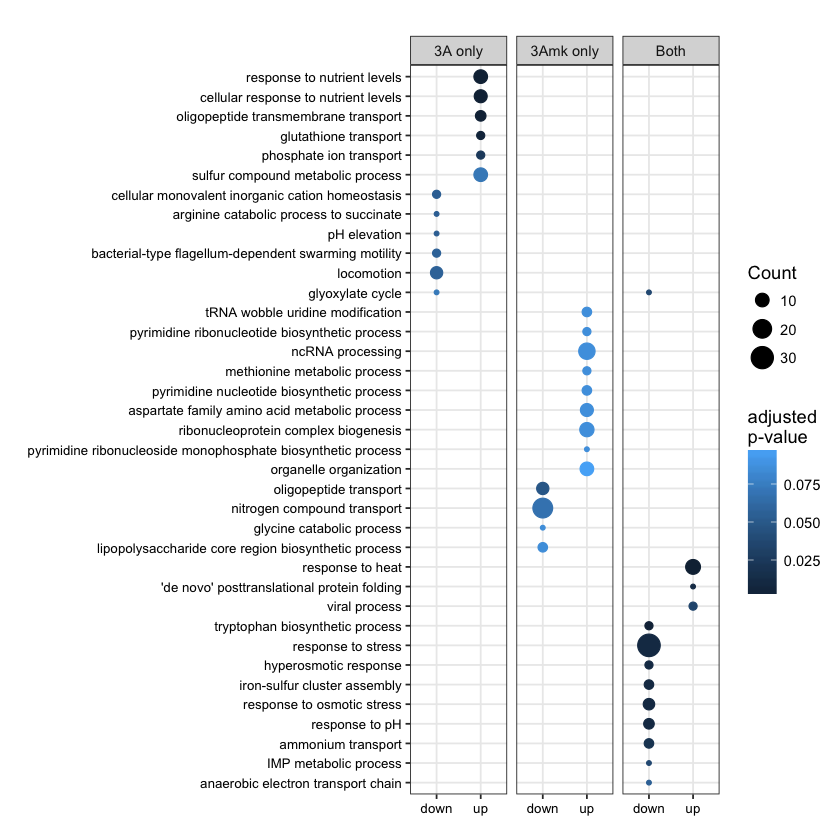

In [22]:
formula_res1_select <- formula_res1
formula_res1_select@compareClusterResult  <- formula_res1_select@compareClusterResult[rownames(unique(formula_res1_select@compareClusterResult[,c('Cluster','geneID')])),]
formula_res1_select <- simplify(x=formula_res1_select, cutoff=0.6)
dp <- dotplot(formula_res1_select, x=~effect, showCategory = 100, by='count', font.size=8) + ggplot2::facet_grid(~strain)
dp <- dp + scale_colour_gradient(name="adjusted\np-value")
#dp <- dp + scale_size_continuous(breaks = c(10,20,30,40),limits = c(0,50))
dp
ggsave("./results/RNA_Seq_GO_1hr.pdf", dp)

#### Generate GO-gene network for visualization

In [23]:
gonet_1 <- setNames(strsplit(formula_res1_select@compareClusterResult$geneID, "/"),
                    formula_res1_select@compareClusterResult$Description)
gonet_terms_1 <- unique(sort(names(gonet_1)))
gonet_1 <- sapply(gonet_terms_1, function(x) symbol2gene[unlist(gonet_1[names(gonet_1) == x],use.names = F),])

gonet_genes_1 <- unique(sort(unlist(gonet_1)))
gonet_nodes_1 <- data.frame(category = c(rep('gene', times = length(gonet_genes_1)), rep('GO', times = length(gonet_1))),
                            row.names = c(gonet_genes_1, names(gonet_1)))
gonet_nodes_1[gonet_genes_1,'3A_1_log2FC'] <- res3A_vs_WT_1[gonet_genes_1,'log2FoldChange']
gonet_nodes_1[gonet_genes_1,'3Amk_1_log2FC'] <- res3Amk_vs_WT_1[gonet_genes_1,'log2FoldChange']
gonet_nodes_1[names(gonet_1),'3A_1_log2FC'] <- sapply(names(gonet_1), function(x) mean(res3A_vs_WT_1[gonet_1[[x]],'log2FoldChange']))
gonet_nodes_1[names(gonet_1),'3Amk_1_log2FC'] <- sapply(names(gonet_1), function(x) mean(res3Amk_vs_WT_1[gonet_1[[x]],'log2FoldChange']))

write(unlist(sapply(names(gonet_1), function(x) paste(x, 'GO', gonet_1[[x]], sep='\t')), use.names = F), file='./results/gonet_1hr.txt')
write.table(as.data.frame(gonet_nodes_1), file='./results/gonet_1hr_nodes.txt', quote=F, sep='\t', col.names = NA)

#### Visualize the network using Cytoscape
run below after running Cytoscape

In [24]:
g <- new('graphNEL', edgemode='directed')
g <- graph::addNode(rownames(gonet_nodes_1), g)

for (go in names(gonet_1)){
    g <- graph::addEdge(go, gonet_1[[go]], g)
}
g <- initNodeAttribute(graph=g, attribute.name = 'Type', 'char', 'gene')
g <- initNodeAttribute(graph=g, '3A_1_log2FC', 'numeric', 0.0)
g <- initNodeAttribute(graph=g, '3Amk_1_log2FC', 'numeric', 0.0)

nodeData(g, names(gonet_1), 'Type') <- 'GO'
nodeData(g, rownames(gonet_nodes_1), '3A_1_log2FC') <- gonet_nodes_1[,'3A_1_log2FC']
nodeData(g, rownames(gonet_nodes_1), '3Amk_1_log2FC') <- gonet_nodes_1[,'3Amk_1_log2FC']

cw <- CytoscapeWindow('GOmap', graph=g, overwriteWindow=TRUE)

displayGraph(cw)
layoutNetwork(cw, 'force-directed-cl') 
setDefaultNodeFontSize(cw, 15)
setNodeShapeRule(cw, node.attribute.name = 'Type', c('gene','GO'), c('ROUND_RECTANGLE','ellipse'))
setNodeSizeRule(cw, node.attribute.name = 'Type', c('gene','GO'), c(30, 100), mode='lookup', default.size = 30)
setNodeOpacityRule(cw, node.attribute.name = 'Type', c('gene','GO'), c(150, 200), mode='lookup', aspect='fill')
setNodeColorRule(cw, node.attribute.name = '3A_1_log2FC', c(-4.0, 0.0, 4.0), c('#00AA00', '#FFFFFF', '#AA0000'), mode='interpolate')
showGraphicsDetails(cw, TRUE)
Sys.sleep(1)
setNodeFontSizeDirect(cw, names(gonet_1), 25)
Sys.sleep(1)
saveImage(cw, './results/3A_1', 'svg')
saveImage(cw, './results/3A_1', 'pdf')
setNodeColorRule(cw, node.attribute.name = '3Amk_1_log2FC', c(-4.0, 0.0, 4.0), c('#00AA00', '#FFFFFF', '#AA0000'), mode='interpolate')
Sys.sleep(1)
setNodeFontSizeDirect(cw, names(gonet_1), 25)
Sys.sleep(1)
saveImage(cw, './results/3Amk_1', 'svg')
saveImage(cw, './results/3Amk_1', 'pdf')

[1] "Type"
[1] "3A_1_log2FC"
[1] "3Amk_1_log2FC"
[1] "label"
Successfully set rule.
Locked node dimensions successfully even if the check box is not ticked.
Locked node dimensions successfully even if the check box is not ticked.
Successfully set rule.
Successfully set rule.
Successfully set rule.
RCy3::showGraphicsDetails(), Switching between show and hide full graphics details.
Successfully set rule.


#### Network at 1 hour post-induction
<img src="results/GO_1hr.svg?sanitize=true" width="800">

#### At 12 hours post-induction

In [25]:
geneList <- rbind(data.frame(gene = na.omit(gene2symbol[setdiff(res3A_12_up,res3Amk_12_up),]), strain='3A only', effect='up'),
                  data.frame(gene = na.omit(gene2symbol[setdiff(res3A_12_down,res3Amk_12_down),]), strain='3A only', effect='down'),
                  data.frame(gene = na.omit(gene2symbol[setdiff(res3Amk_12_up,res3A_12_up),]), strain='3Amk only', effect='up'),
                  data.frame(gene = na.omit(gene2symbol[setdiff(res3Amk_12_down,res3A_12_down),]), strain='3Amk only', effect='down'),
                  data.frame(gene = na.omit(gene2symbol[intersect(res3A_12_up,res3Amk_12_up),]), strain='Both', effect='up'),
                  data.frame(gene = na.omit(gene2symbol[intersect(res3A_12_down,res3Amk_12_down),]), strain='Both', effect='down'))

formula_res12 <- compareCluster(gene ~ strain + effect, data=geneList, fun="enrichGO",
                                universe = keys(org.EcK12.eg.db, keytype = "SYMBOL"), OrgDb = org.EcK12.eg.db,
                                keytype = "SYMBOL", ont = "BP", pAdjustMethod = "BH",
                                pvalueCutoff = alpha, qvalueCutoff = 0.1, minGSSize = 3)

#### Save the results to a text file

In [26]:
head(formula_res12@compareClusterResult)
write.table(formula_res12@compareClusterResult, file='./results/gotable_12hr.txt', quote=F, sep='\t', col.names = NA)

Cluster,strain,effect,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
3A only.up,3A only,up,GO:0009081,branched-chain amino acid metabolic process,9/224,21/2531,3.247522e-05,0.02209359,0.02134730,leuD/leuC/leuB/leuA/panE/ilvB/ilvE/ilvD/ilvA,9
3A only.up,3A only,up,GO:0009082,branched-chain amino acid biosynthetic process,8/224,18/2531,6.668322e-05,0.02209359,0.02134730,leuD/leuC/leuB/leuA/ilvB/ilvE/ilvD/ilvA,8
3A only.up,3A only,up,GO:0006097,glyoxylate cycle,5/224,7/2531,9.421574e-05,0.02209359,0.02134730,acnB/prpB/acnA/glcB/aceB,5
3A only.up,3A only,up,GO:0019541,propionate metabolic process,5/224,7/2531,9.421574e-05,0.02209359,0.02134730,acnB/prpB/prpC/prpD/ackA,5
3A only.up,3A only,up,GO:0044283,small molecule biosynthetic process,35/224,214/2531,1.526997e-04,0.02256805,0.02180573,thrB/pdxA/leuD/leuC/leuB/leuA/ispU/fabZ/proB/proA/dxs/yajL/panE/ybjI/mgsA/purU/fabI/folM/ribC/ppsA/hchA/ackA/aroC/alaC/cysK/gabT/folP/ilvB/ilvM/ilvE/ilvD/ilvA/argE/birA/fbp,35
3A only.up,3A only,up,GO:0010876,lipid localization,8/224,20/2531,1.640745e-04,0.02256805,0.02180573,acrA/putP/lolB/mlaC/mlaE/mlaF/lptB/yhjD,8


#### Simplify similar GO terms

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


Saving 7 x 7 in image


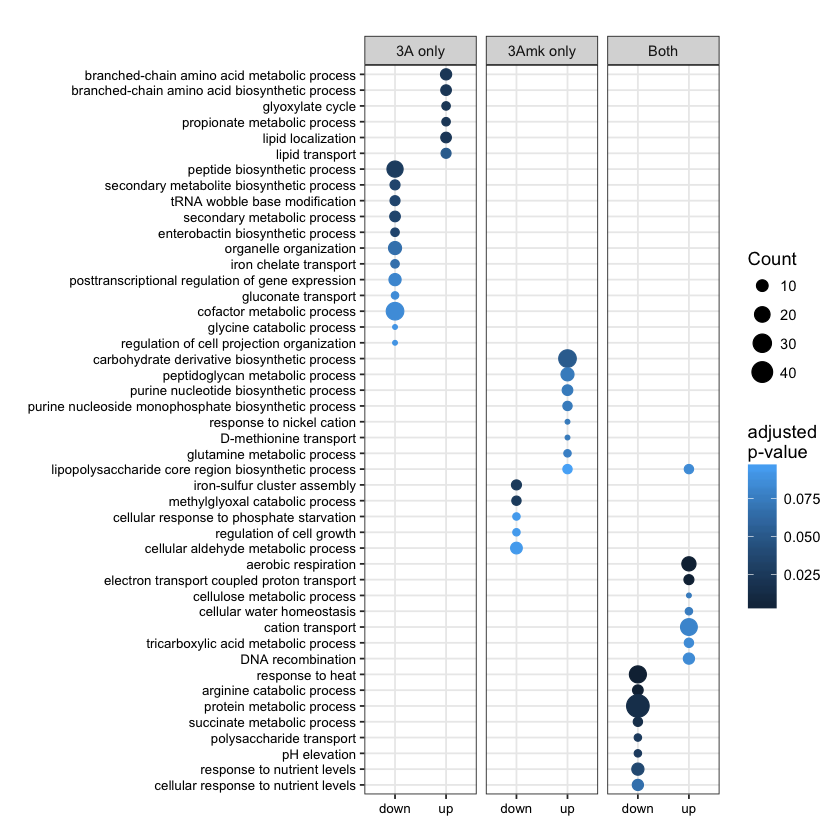

In [27]:
formula_res12_select <- formula_res12
formula_res12_select@compareClusterResult  <- formula_res12_select@compareClusterResult[rownames(unique(formula_res12_select@compareClusterResult[,c('Cluster','geneID')])),]
formula_res12_select <- simplify(x=formula_res12_select, cutoff=0.6)
formula_res12_select@compareClusterResult[formula_res12_select@compareClusterResult$ID == 'GO:0015988',] <-
    formula_res12@compareClusterResult[formula_res12@compareClusterResult$ID == 'GO:0015990',]
dp <- dotplot(formula_res12_select, x=~effect, showCategory = 100, by='count', font.size=8) + ggplot2::facet_grid(~strain)
dp <- dp + scale_colour_gradient(name="adjusted\np-value")
#dp <- dp + scale_size_continuous(breaks = c(10,20,30,40), limits = c(0,50))
dp
ggsave("./results/RNA_Seq_GO_12hr.pdf", dp)

#### Generate GO-gene network for visualization

In [28]:
gonet_12 <- setNames(strsplit(formula_res12_select@compareClusterResult$geneID, "/"),
                    formula_res12_select@compareClusterResult$Description)
gonet_terms_12 <- unique(sort(names(gonet_12)))
gonet_12 <- sapply(gonet_terms_12, function(x) symbol2gene[unlist(gonet_12[names(gonet_12) == x],use.names = F),])

gonet_genes_12 <- unique(sort(unlist(gonet_12)))
gonet_nodes_12 <- data.frame(category = c(rep('gene', times = length(gonet_genes_12)), rep('GO', times = length(gonet_12))),
                            row.names = c(gonet_genes_12, names(gonet_12)))
gonet_nodes_12[gonet_genes_12,'3A_12_log2FC'] <- res3A_vs_WT_12[gonet_genes_12,'log2FoldChange']
gonet_nodes_12[gonet_genes_12,'3Amk_12_log2FC'] <- res3Amk_vs_WT_12[gonet_genes_12,'log2FoldChange']
gonet_nodes_12[names(gonet_12),'3A_12_log2FC'] <- sapply(names(gonet_12), function(x) mean(res3A_vs_WT_12[gonet_12[[x]],'log2FoldChange']))
gonet_nodes_12[names(gonet_12),'3Amk_12_log2FC'] <- sapply(names(gonet_12), function(x) mean(res3Amk_vs_WT_12[gonet_12[[x]],'log2FoldChange']))

write(unlist(sapply(names(gonet_12), function(x) paste(x, 'GO', gonet_12[[x]], sep='\t')), use.names = F), file='./results/gonet_12hr.txt')
write.table(as.data.frame(gonet_nodes_12), file='./results/gonet_12hr_nodes.txt', quote=F, sep='\t', col.names = NA)

#### Visualize the network using Cytoscape
run below after running Cytoscape

In [29]:
g <- new('graphNEL', edgemode='directed')
g <- graph::addNode(rownames(gonet_nodes_12), g)

for (go in names(gonet_12)){
    g <- graph::addEdge(go, gonet_12[[go]], g)
}
g <- initNodeAttribute(graph=g, attribute.name = 'Type', 'char', 'gene')
g <- initNodeAttribute(graph=g, '3A_12_log2FC', 'numeric', 0.0)
g <- initNodeAttribute(graph=g, '3Amk_12_log2FC', 'numeric', 0.0)

nodeData(g, names(gonet_12), 'Type') <- 'GO'
nodeData(g, rownames(gonet_nodes_12), '3A_12_log2FC') <- gonet_nodes_12[,'3A_12_log2FC']
nodeData(g, rownames(gonet_nodes_12), '3Amk_12_log2FC') <- gonet_nodes_12[,'3Amk_12_log2FC']

cw <- CytoscapeWindow('GOmap', graph=g, overwriteWindow=TRUE)

displayGraph(cw)
layoutNetwork(cw, 'force-directed-cl') 
setDefaultNodeFontSize(cw, 15)
setNodeShapeRule(cw, node.attribute.name = 'Type', c('gene','GO'), c('ROUND_RECTANGLE','ellipse'))
setNodeSizeRule(cw, node.attribute.name = 'Type', c('gene','GO'), c(30, 60), mode='lookup', default.size = 30)
setNodeOpacityRule(cw, node.attribute.name = 'Type', c('gene','GO'), c(150, 200), mode='lookup', aspect='fill')
setNodeColorRule(cw, node.attribute.name = '3A_12_log2FC', c(-4.0, 0.0, 4.0), c('#00AA00', '#FFFFFF', '#AA0000'), mode='interpolate')
showGraphicsDetails(cw, TRUE)
Sys.sleep(1)
setNodeFontSizeDirect(cw, names(gonet_12), 25)
Sys.sleep(1)
saveImage(cw, './results/3A_12', 'svg')
saveImage(cw, './results/3A_12', 'pdf')
setNodeColorRule(cw, node.attribute.name = '3Amk_12_log2FC', c(-4.0, 0.0, 4.0), c('#00AA00', '#FFFFFF', '#AA0000'), mode='interpolate')
Sys.sleep(1)
setNodeFontSizeDirect(cw, names(gonet_12), 25)
Sys.sleep(1)
saveImage(cw, './results/3Amk_12', 'svg')
saveImage(cw, './results/3Amk_12', 'pdf')

[1] "Type"
[1] "3A_12_log2FC"
[1] "3Amk_12_log2FC"
[1] "label"
Successfully set rule.
Locked node dimensions successfully even if the check box is not ticked.
Locked node dimensions successfully even if the check box is not ticked.
Successfully set rule.
Successfully set rule.
Successfully set rule.
RCy3::showGraphicsDetails(), Switching between show and hide full graphics details.
Successfully set rule.


#### Network at 12 hours post-induction
<img src="results/GO_12hr.svg?sanitize=true" width="800">